# Advanced Regression Techniques

Kaggle Competition found here https://www.kaggle.com/c/house-prices-advanced-regression-techniques/ 

Where we will predict sales prices and practice feature engineering, RFs, and gradient boosting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

It is my job to predict the sales price for each house. For each Id in the test set, I must predict the value of the SalePrice variable. 

## Importing Data

In [2]:
data_train = pd.read_csv('C:/Users/Kycool13/Documents/GitHub/Kaggle/House_Prices-Advanced_Regression/train.csv')
data_test = pd.read_csv('C:/Users/Kycool13/Documents/GitHub/Kaggle/House_Prices-Advanced_Regression/test.csv')

## Data Exploration        

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
data_train.shape

(1460, 81)

Here we see this data set contains  81 explanatory variables with 1460 houses sold. 

In [5]:
data_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Now let's check for missing values

In [6]:
data_train.columns[data_train.isnull().any()]

Index([u'LotFrontage', u'Alley', u'MasVnrType', u'MasVnrArea', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2',
       u'Electrical', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish', u'GarageQual', u'GarageCond', u'PoolQC', u'Fence',
       u'MiscFeature'],
      dtype='object')

These 19 features all have missing values. Let's see how many missing values are in each column.

In [7]:
#Missing value counts in each of these columns
miss = data_train.isnull().sum()/len(data_train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

Alley, MiscFeature, and PoolQC all have a large percent missing. Let's visualize the missing values. 

AttributeError: 'module' object has no attribute 'plt'

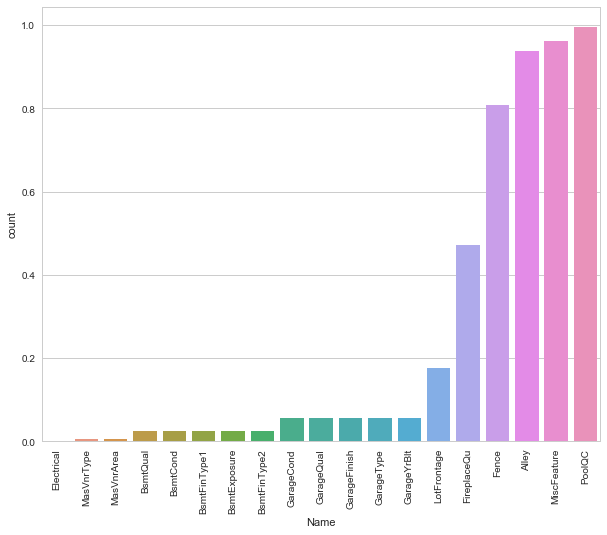

In [8]:
#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
sns.plt.show()

Let's look at the Target Variable: SalePrice

In [11]:
data_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Let's get and idea of the distribution and check for skewness. 

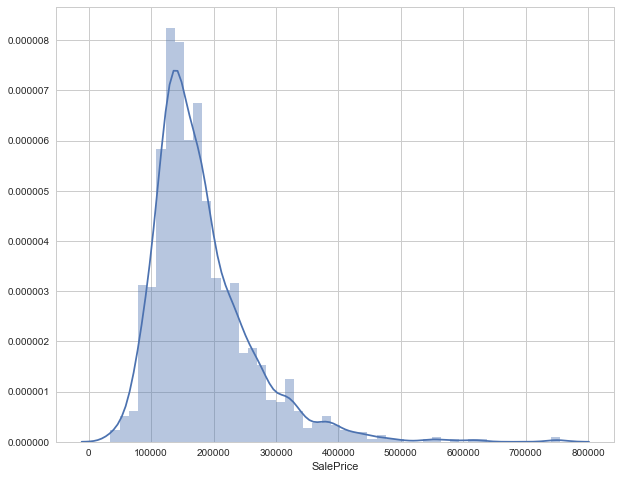

In [12]:
sns.distplot(data_train['SalePrice'])

We can see the distribution is right-skewed. To make this distribution more normally distributed let's log transform it. We do this because a normally distributed target variable helps in better modeling the relationship between the taget and other independent variables. 

Let's log-transform this data

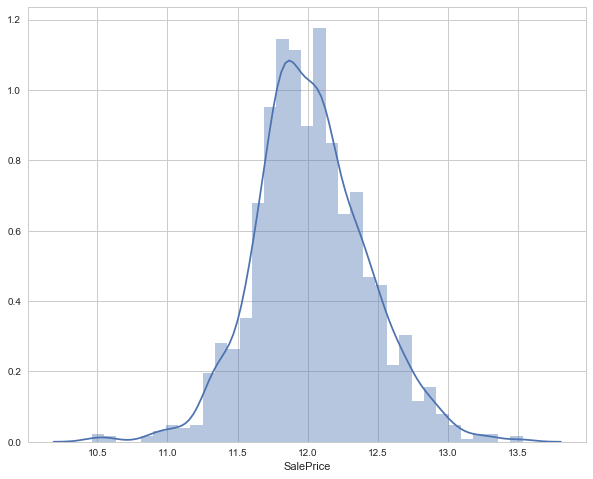

In [13]:
target = np.log(data_train['SalePrice'])
sns.distplot(target)

Let's split our data into categorical, and numerical to explore each separately.

In [17]:
#Separate variables into new data frames
numeric_data = data_train.select_dtypes(include=[np.number])
cat_data = data_train.select_dtypes(exclude=[np.number])
print "There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1])

There are 37 numeric and 43 categorical columns in train data


Since Id is a number, but not a numeric value we should drop it. 

In [16]:
data_train.drop("Id", axis = 1, inplace = True)

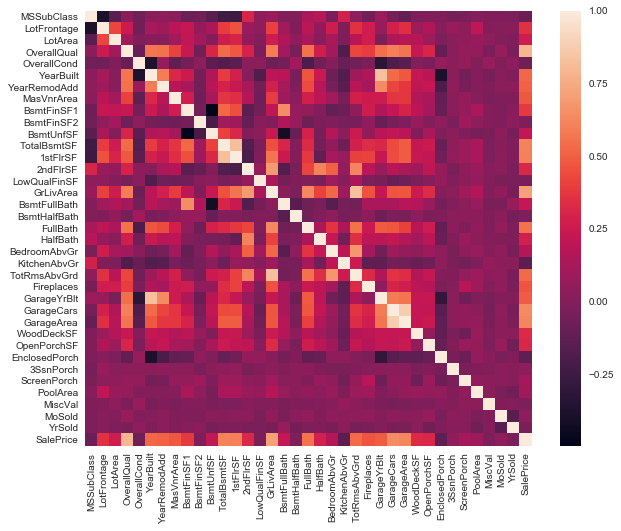

In [18]:
corr = numeric_data.corr()
sns.heatmap(corr)

We can see that for SalePrice there are a few variables correlated, but it's tough. Let's use a numeric correclation score, to better understand the graph.

In [19]:
print corr['SalePrice'].sort_values(ascending=False)[:15], '\n'

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 



Let's start by inspecting the numerical variables like GrLivArea and TotalBsmtSF, and then move on to categorical variables like OverallQual

### Numerical Variables

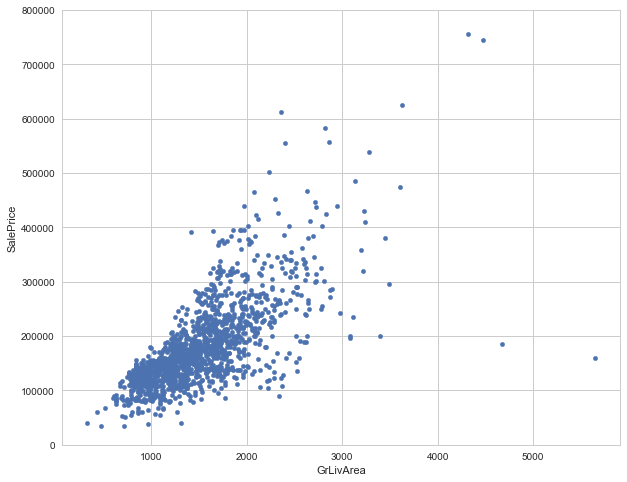

In [23]:
#ScatterPlot of GrLivArea v SalePrice
var = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

We see a direct correlation with living area and SalePrice. We notice a few extreme values. Two possible outliers in the bottom right. They appear to be very large houses that sold for cheap.

 ### Categorical Variables

In [24]:
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Getting back to Overal Quality vs SalePrice

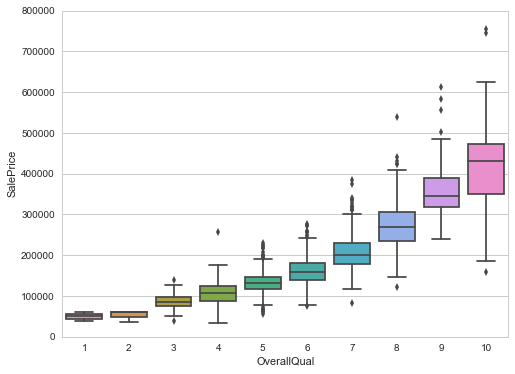

In [26]:
#box plot Overall Quality vs Sales Price
var = 'OverallQual'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);